In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Grouper

import statsmodels.formula.api as smf
from math import sqrt
from sklearn import metrics

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Loading the data

In [3]:
g_df=pd.read_csv("C:\\Users\\Mani\\Desktop\\Project\\Gold_data.csv")

In [4]:
g_df.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [5]:
g_df.set_index('date',inplace=True)

In [6]:
# Diving data into 80:20 ratio

train=g_df.iloc[0:1745]
test=g_df.iloc[1745:]

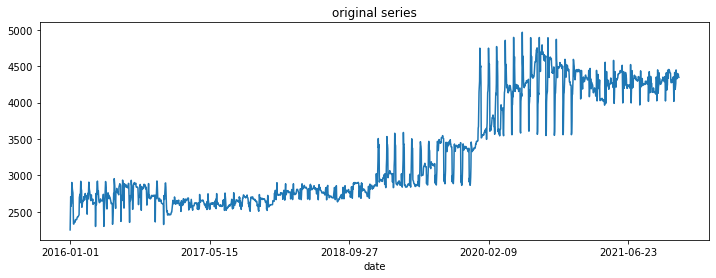

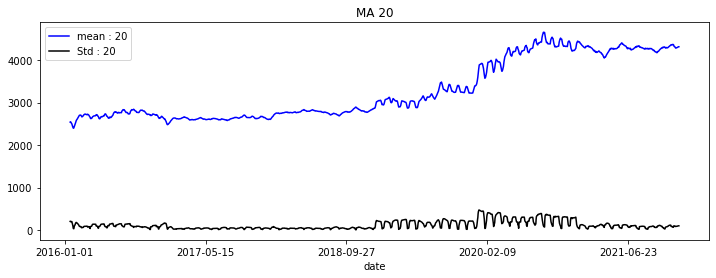

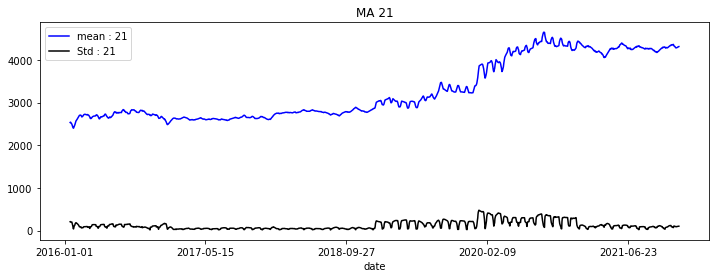

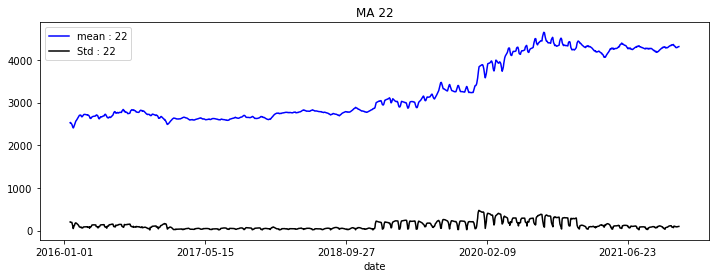

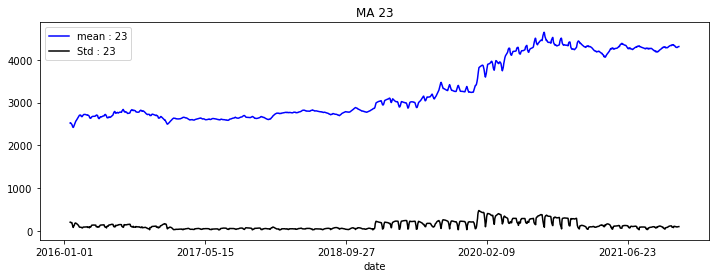

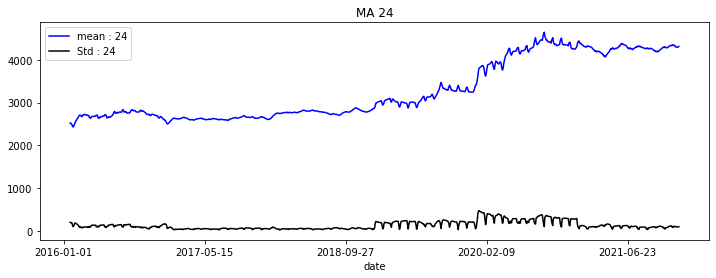

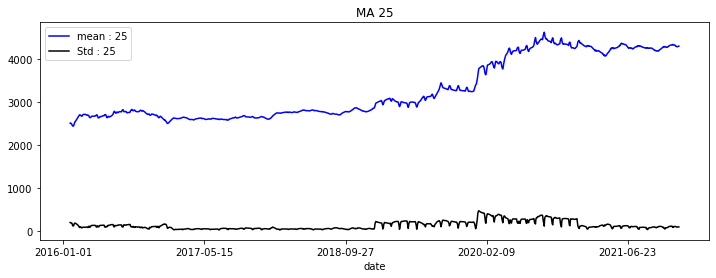

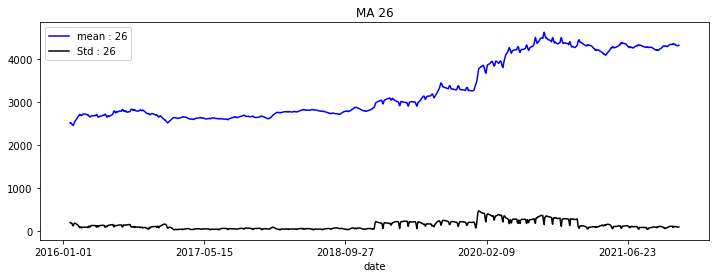

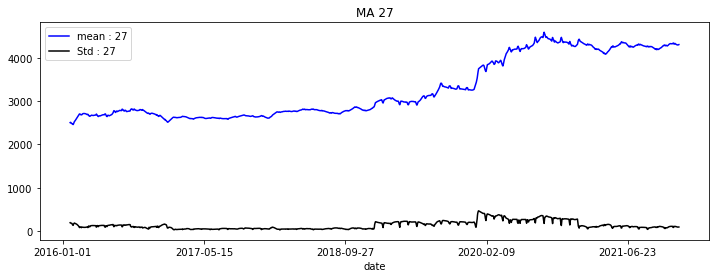

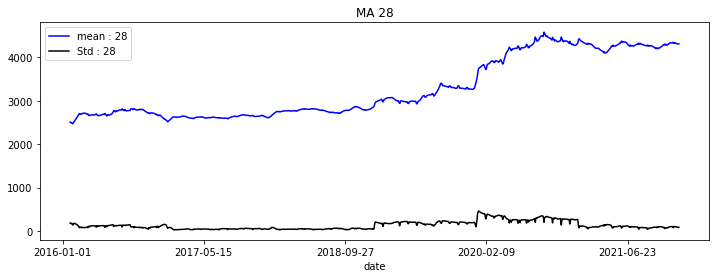

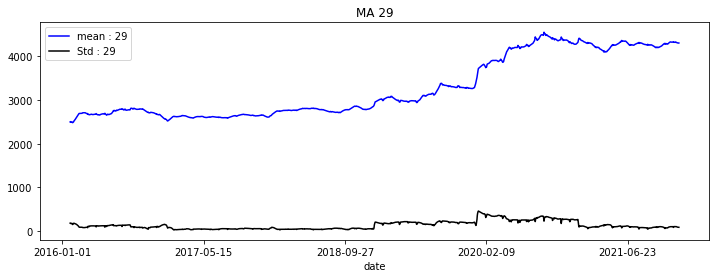

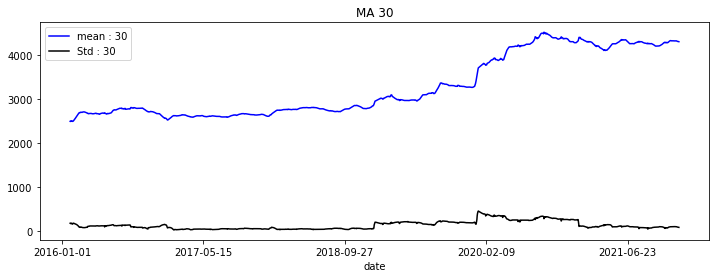

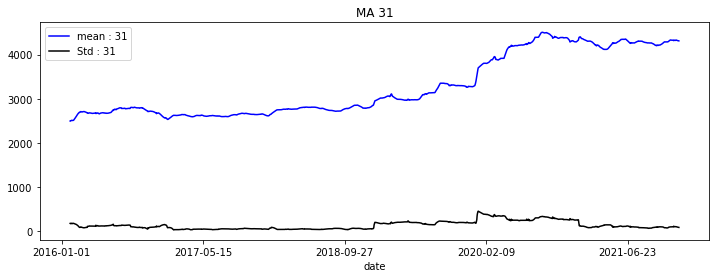

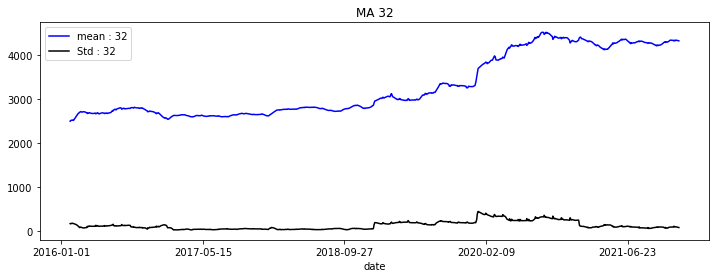

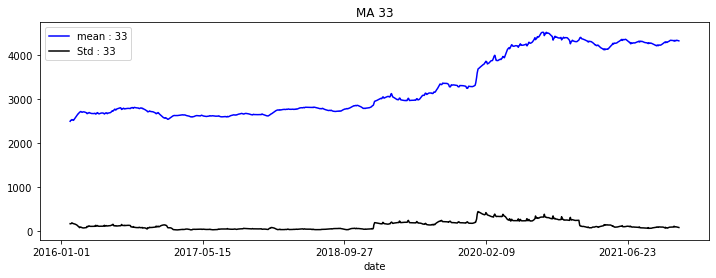

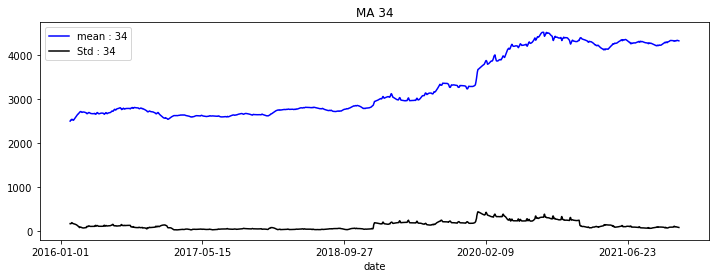

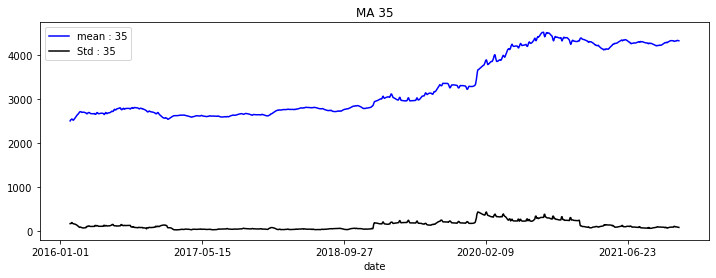

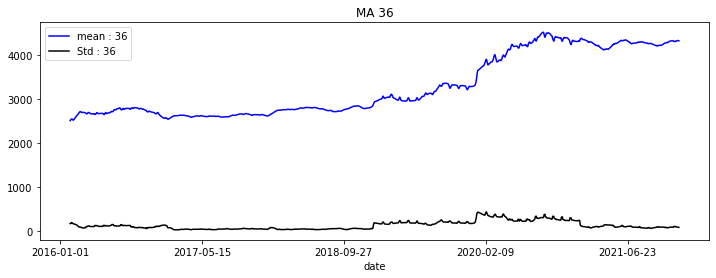

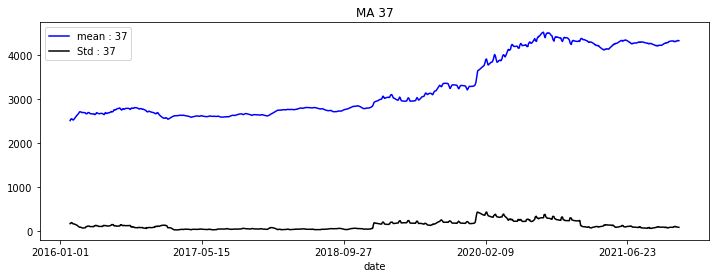

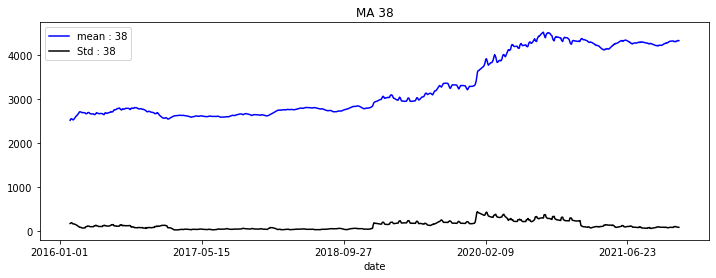

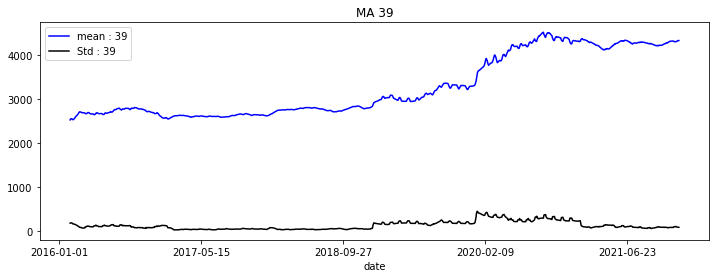

In [7]:
# to find the Window size or frequency :

plt.figure(figsize=(12,4))
g_df.price.plot(label="price")
plt.title("original series")

for i in range(20,40):
    plt.figure(figsize=(12,4))


    g_df["price"].rolling(i).mean().plot(label="mean : "+str(i),color='blue')
    g_df["price"].rolling(i).std().plot(label="Std : "+str(i),color='black')
    plt.title("MA "+str(i))
    plt.legend(loc='best')
    plt.show()

- Rolling mean is showing some trend in all the cases.
- Standard deviation is also not constant.
- we can say that the data is not stationary.

# Transformations :

In [8]:
g_df["log_trans"]=np.log(g_df.price)

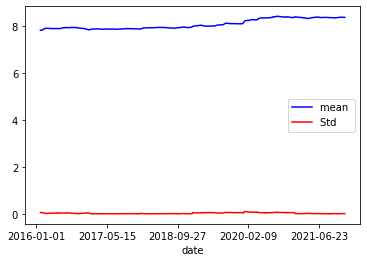

In [9]:
g_df["log_trans"].rolling(30).mean().plot(label="mean ",color='blue')
g_df["log_trans"].rolling(30).std().plot(label="Std ",color='red')
plt.legend()
plt.show()

In [10]:
adf = adfuller(g_df["log_trans"].dropna())
adfoutput = pd.Series(adf[0:3], index=['Test Statistic','p-value','#Lags Used'])
print(adfoutput)

Test Statistic    -0.457214
p-value            0.900099
#Lags Used        26.000000
dtype: float64


- After applying log transformation , we were able to get a constant mean and variance  but , we have got a p-value of 0.9 

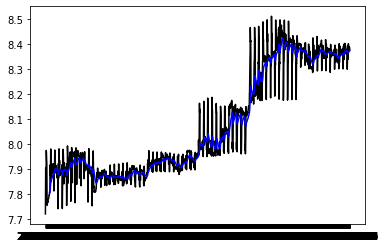

In [11]:
ewma_price = g_df["log_trans"].ewm(halflife=12, min_periods=30, adjust=True).mean()
plt.plot(g_df["log_trans"], color='black')
plt.plot(ewma_price, color='blue')

In [12]:
rem_log_ewma_price =  g_df["log_trans"] - ewma_price

In [13]:
adf = adfuller(rem_log_ewma_price.dropna())
adfoutput = pd.Series(adf[0:3], index=['Test Statistic','p-value','#Lags Used'])
print(adfoutput)

Test Statistic   -8.766170e+00
p-value           2.594091e-14
#Lags Used        2.600000e+01
dtype: float64


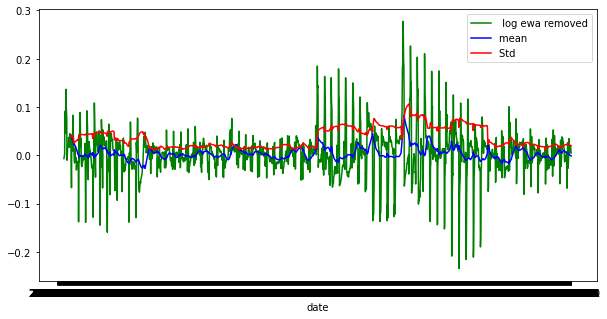

In [14]:
plt.figure(figsize=(10,5))
#plt.plot(g_df["price"],label="original price  ",color='black')
plt.plot(rem_log_ewma_price,label=" log ewa removed", color='green')
rem_log_ewma_price.rolling(30).mean().plot(label="mean ",color='blue')
rem_log_ewma_price.rolling(30).std().plot(label="Std ",color='red')
plt.legend()
plt.show()

In [17]:
# Time shift Transformation 

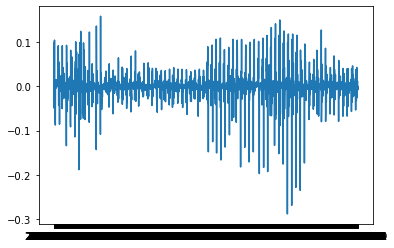

In [16]:
diff_log_price=g_df["log_trans"]-g_df["log_trans"].shift()
plt.plot(diff_log_price)

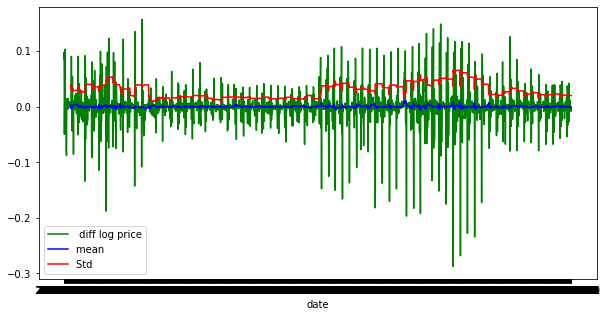

In [18]:
plt.figure(figsize=(10,5))
#plt.plot(g_df["price"],label="original price  ",color='black')
plt.plot(diff_log_price,label=" diff log price", color='green')
diff_log_price.rolling(30).mean().plot(label="mean ",color='blue')
diff_log_price.rolling(30).std().plot(label="Std ",color='red')
plt.legend()
plt.show()

In [19]:
adf = adfuller(diff_log_price.dropna())
adfoutput = pd.Series(adf[0:3], index=['Test Statistic','p-value','#Lags Used'])
print(adfoutput)

Test Statistic   -21.394232
p-value            0.000000
#Lags Used        26.000000
dtype: float64


- After removing the wrighted average from the original price we got a constant mean and variance .
- p-value is also less than 0.05 i.e., the data is stationary now.

In [ ]:
# ACF and PACF plots

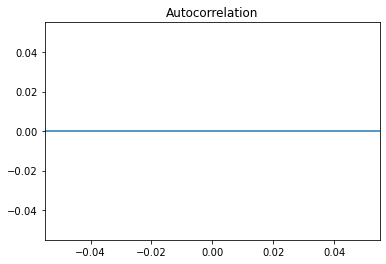

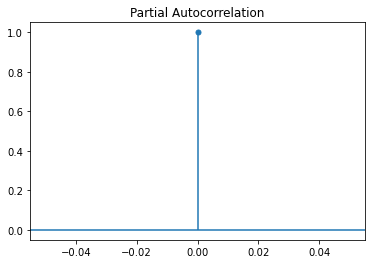

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(rem_ewma_price,lags=30,ax=None)
plot_pacf(rem_ewma_price,lags=90,ax=None)
plt.show()

In [21]:
diff_log_price.dropna(inplace=True)

In [22]:
diff_log_price.shape

(2181,)

# Model Building :

### AR model : As we see the ACF plot is reducing exponentially 

In [32]:
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# train test split

In [23]:
train=diff_log_price[0:1722]
test=diff_log_price[1722:]

In [34]:
############## Build AR model using ARIMA :  ( But this was not accepting lags > 2 .... so, go for AutoReg model of stats)

for i in range(0,5):
    for j in range(0,5):
        try:
            model = ARIMA(train, order=(i,j,0))
            results_AR = model.fit()
            if(j==0):
                rmse = sqrt(mean_squared_error(train, results_AR.fittedvalues))
            else :
                rmse = sqrt(mean_squared_error(train[0:-j], results_AR.fittedvalues))
            print("rmse for p= ",i,", d=",j,"  :  ",rmse)
        except Exception as e :
                    print(e)
                    continue

rmse for p=  0 , d= 0   :   156.5191037745226
rmse for p=  0 , d= 1   :   157.21786332174867
rmse for p=  0 , d= 2   :   157.2557301836933
d > 2 is not supported
d > 2 is not supported
rmse for p=  1 , d= 0   :   103.32506910255087
rmse for p=  1 , d= 1   :   157.83395791343435
rmse for p=  1 , d= 2   :   137.20540462148932
d > 2 is not supported
d > 2 is not supported
rmse for p=  2 , d= 0   :   102.5250234735168
rmse for p=  2 , d= 1   :   164.8855902178187
rmse for p=  2 , d= 2   :   134.4234937263743
d > 2 is not supported
d > 2 is not supported
rmse for p=  3 , d= 0   :   102.48166402449058
rmse for p=  3 , d= 1   :   165.36043289501268
rmse for p=  3 , d= 2   :   133.02779861023444
d > 2 is not supported
d > 2 is not supported
rmse for p=  4 , d= 0   :   101.8298421083663
rmse for p=  4 , d= 1   :   167.8546062149221
rmse for p=  4 , d= 2   :   134.14801519805332
d > 2 is not supported
d > 2 is not supported


### AR model using AutoReg :

In [28]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [25]:
model_AR = AutoReg(train, lags = 10).fit()  # fit the model with lags upto 10 
print(model_AR.summary()) # summary of the model

                            AutoReg Model Results                             
Dep. Variable:              log_trans   No. Observations:                 1722
Model:                    AutoReg(10)   Log Likelihood                3520.234
Method:               Conditional MLE   S.D. of innovations              0.031
Date:                Thu, 28 Apr 2022   AIC                             -6.936
Time:                        15:27:32   BIC                             -6.898
Sample:                    01-12-2016   HQIC                            -6.922
                         - 09-18-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0006      0.001      0.807      0.420      -0.001       0.002
log_trans.L1     -0.0616      0.024     -2.554      0.011      -0.109      -0.014
log_trans.L2     -0.1495      0.024     

C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


- p-value indicates how important is each lag in making predictions.

In [29]:
pred_AR=model_AR.predict(start=len(train), end=(len(diff_log_price)-1)) # predecting the values using AR for last 20% of the days
rmse_AR=sqrt(mean_squared_error(test, pred_AR))  # error calculation using rmse
print("RMSE for AR :", rmse_AR)

RMSE for AR : 0.029818001562605386


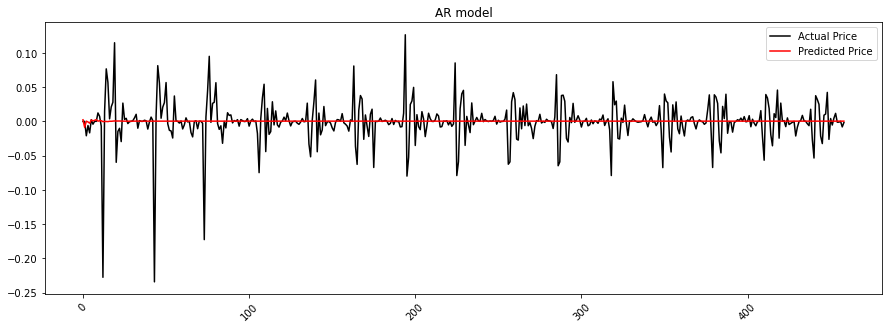

In [30]:
# Ploting the predictions:

plt.figure(figsize=(15,5))
plt.title("AR model")
plt.xticks(rotation=45)
plt.plot(test.values, color='black',label='Actual Price')
plt.plot(pred_AR.values,color='red', label='Predicted Price')
plt.legend()

### MA model :

In [33]:
#MA Model using ARIMA :

for i in range(0,5):
    for j in range(0,5):
        try:
            model_MA = ARIMA(train, order=(0,j,i)).fit()
            pred_MA=model_MA.predict(start=len(train), end=(len(diff_log_price)-1))
            rmse = sqrt(mean_squared_error(test, pred_MA))
            print("rmse for q= ",i,", d=",j,"  :  ",rmse)
        except Exception as e :
                    print(e)
                    continue

C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was 

rmse for q=  0 , d= 0   :   0.029827549304673164
rmse for q=  0 , d= 1   :   0.02982270438362433
rmse for q=  0 , d= 2   :   0.029822867049642595
d > 2 is not supported
d > 2 is not supported
rmse for q=  1 , d= 0   :   0.02982753457815025
rmse for q=  1 , d= 1   :   0.029823178536564167


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  1 , d= 2   :   0.029827179774223552
d > 2 is not supported
d > 2 is not supported
rmse for q=  2 , d= 0   :   0.029827349663351294


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  2 , d= 1   :   0.029823186198879012


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  2 , d= 2   :   0.029830386092651623
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  3 , d= 0   :   0.029827235425192253


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  3 , d= 1   :   0.029823777253605344


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  3 , d= 2   :   0.029829901161525185
d > 2 is not supported
d > 2 is not supported
rmse for q=  4 , d= 0   :   0.029823292641651736


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  4 , d= 1   :   0.02982347581111673


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for q=  4 , d= 2   :   0.029831728187107907
d > 2 is not supported
d > 2 is not supported


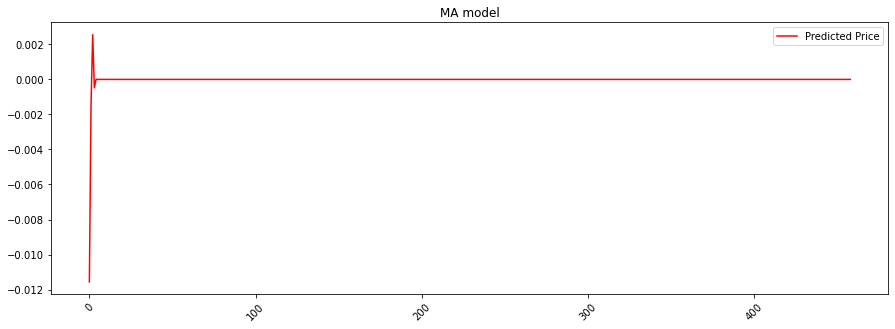

In [35]:
# Ploting the predictions:

plt.figure(figsize=(15,5))
plt.title("MA model")
plt.xticks(rotation=45)
#plt.plot(test.values, color='black',label='Actual Price')
plt.plot(pred_MA.values,color='red', label='Predicted Price')
plt.legend()

### ARMA Model: 

In [20]:
#ARMA Model

for i in range(0,5):
    for j in range(0,5):
        try:
            model_ARMA = ARIMA(train, order=(i,0,j)).fit()
            pred_ARMA= model_ARMA.predict(start=len(train), end=(len(rem_ewma_price)-1))
            rmse_ARMA = sqrt(mean_squared_error(test, pred_ARMA))
            print("rmse for p= ",i,", q=",j,"  :  ",rmse_ARMA)
        except Exception as e :
                    print(e)
                    continue

rmse for p=  0 , q= 0   :   207.62719944557517
rmse for p=  0 , q= 1   :   207.62828095189
rmse for p=  0 , q= 2   :   207.63223359776086
rmse for p=  0 , q= 3   :   207.6324717022547
rmse for p=  0 , q= 4   :   207.63360324204038
rmse for p=  1 , q= 0   :   207.64274507628193
rmse for p=  1 , q= 1   :   207.63987865625234
rmse for p=  1 , q= 2   :   207.6395424925982
rmse for p=  1 , q= 3   :   207.638768711302
rmse for p=  1 , q= 4   :   207.63878965303508
rmse for p=  2 , q= 0   :   207.63947137763006
rmse for p=  2 , q= 1   :   207.63892931452426
rmse for p=  2 , q= 2   :   207.6386308754292
rmse for p=  2 , q= 3   :   207.63831417279556
rmse for p=  2 , q= 4   :   207.6383863283431
rmse for p=  3 , q= 0   :   207.6393278987212
rmse for p=  3 , q= 1   :   207.63902821768113
rmse for p=  3 , q= 2   :   207.63772321035373
rmse for p=  3 , q= 3   :   207.63764580304075
rmse for p=  3 , q= 4   :   207.63847061688085
rmse for p=  4 , q= 0   :   207.6384788425505
rmse for p=  4 , q= 1   

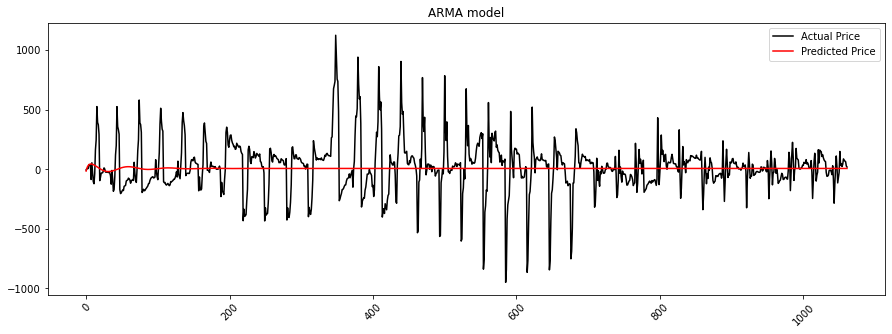

In [21]:
# Ploting the predictions:

plt.figure(figsize=(15,5))
plt.title("ARMA model")
plt.xticks(rotation=45)
plt.plot(test.values, color='black',label='Actual Price')
plt.plot(pred_ARMA.values,color='red', label='Predicted Price')
plt.legend()

### ARIMA :

In [17]:
for i in range(0,5):
    for j in range(0,5):
        for k in range(0,5):
            try:
                model_ARIMA = ARIMA(train, order=(i,k,j)).fit()
                pred_ARIMA= model_ARIMA.predict(start=len(train), end=(len(rem_ewma_price)-1))
                rmse_ARIMA = sqrt(mean_squared_error(test, pred_ARIMA))
                print("rmse for p= ",i,",d=",k,", q=",j,"  :  ",rmse_ARIMA)
            except Exception as e :
                        print(e)
                        continue

C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was 

rmse for p=  0 ,d= 0 , q= 0   :   207.62719944557517
rmse for p=  0 ,d= 1 , q= 0   :   208.27085395100065
rmse for p=  0 ,d= 2 , q= 0   :   208.27034520988735
d > 2 is not supported
d > 2 is not supported
rmse for p=  0 ,d= 0 , q= 1   :   207.62828095189
rmse for p=  0 ,d= 1 , q= 1   :   208.27090652332313
rmse for p=  0 ,d= 2 , q= 1   :   208.26907950214022
d > 2 is not supported
d > 2 is not supported
rmse for p=  0 ,d= 0 , q= 2   :   207.63223359776086
rmse for p=  0 ,d= 1 , q= 2   :   208.27475729481458


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was 

rmse for p=  0 ,d= 2 , q= 2   :   208.26926026679726
d > 2 is not supported
d > 2 is not supported
rmse for p=  0 ,d= 0 , q= 3   :   207.6324717022547


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  0 ,d= 1 , q= 3   :   208.27721363519734


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  0 ,d= 2 , q= 3   :   208.26950932800295
d > 2 is not supported
d > 2 is not supported
rmse for p=  0 ,d= 0 , q= 4   :   207.63360324204038


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  0 ,d= 1 , q= 4   :   208.2731408643708


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  0 ,d= 2 , q= 4   :   208.27991513548534
d > 2 is not supported
d > 2 is not supported
rmse for p=  1 ,d= 0 , q= 0   :   207.64274507628193
rmse for p=  1 ,d= 1 , q= 0   :   208.27087604331234
rmse for p=  1 ,d= 2 , q= 0   :   208.27024615291714
d > 2 is not supported
d > 2 is not supported
rmse for p=  1 ,d= 0 , q= 1   :   207.63987865625234


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was 

rmse for p=  1 ,d= 1 , q= 1   :   208.2681802980285
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported
rmse for p=  1 ,d= 0 , q= 2   :   207.6395424925982


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  1 ,d= 1 , q= 2   :   208.268483034514
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  1 ,d= 0 , q= 3   :   207.638768711302


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  1 ,d= 1 , q= 3   :   208.26851242880596
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  1 ,d= 0 , q= 4   :   207.63878965303508


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  1 ,d= 1 , q= 4   :   208.26856102264966
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported
rmse for p=  2 ,d= 0 , q= 0   :   207.63947137763006
rmse for p=  2 ,d= 1 , q= 0   :   208.27086188698647


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was 

rmse for p=  2 ,d= 2 , q= 0   :   208.27044525825676
d > 2 is not supported
d > 2 is not supported
rmse for p=  2 ,d= 0 , q= 1   :   207.63892931452426


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  2 ,d= 1 , q= 1   :   208.2685127184112
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  2 ,d= 0 , q= 2   :   207.6386308754292


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  2 ,d= 1 , q= 2   :   208.268204237398
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  2 ,d= 0 , q= 3   :   207.63831417279556


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  2 ,d= 1 , q= 3   :   208.26832527536698
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  2 ,d= 0 , q= 4   :   207.6383863283431


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  2 ,d= 1 , q= 4   :   208.26841025968068
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported
rmse for p=  3 ,d= 0 , q= 0   :   207.6393278987212
rmse for p=  3 ,d= 1 , q= 0   :   208.2710434223512


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was 

rmse for p=  3 ,d= 2 , q= 0   :   208.27226556366392
d > 2 is not supported
d > 2 is not supported
rmse for p=  3 ,d= 0 , q= 1   :   207.63902821768113


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  3 ,d= 1 , q= 1   :   208.26853050563057
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  3 ,d= 0 , q= 2   :   207.63772321035373


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  3 ,d= 1 , q= 2   :   208.2683536543817
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  3 ,d= 0 , q= 3   :   207.63764580304075


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  3 ,d= 1 , q= 3   :   208.2684609121037
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  3 ,d= 0 , q= 4   :   207.63847061688085


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information wa

rmse for p=  3 ,d= 1 , q= 4   :   208.29525501262063
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported
rmse for p=  4 ,d= 0 , q= 0   :   207.6384788425505
rmse for p=  4 ,d= 1 , q= 0   :   208.2728164499879


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  4 ,d= 2 , q= 0   :   208.2727860868202
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  4 ,d= 0 , q= 1   :   207.63795044044318


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  4 ,d= 1 , q= 1   :   208.2685731687722
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  4 ,d= 0 , q= 2   :   207.9123259210133


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  4 ,d= 1 , q= 2   :   208.26842473258986
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


rmse for p=  4 ,d= 0 , q= 3   :   208.67611119319267


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information wa

rmse for p=  4 ,d= 1 , q= 3   :   208.27880828695706
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported
rmse for p=  4 ,d= 0 , q= 4   :   207.73324904242267
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
d > 2 is not supported
d > 2 is not supported


C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


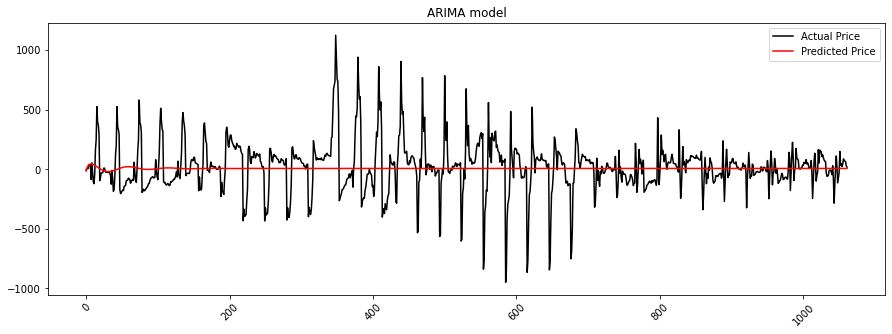

In [18]:
# Ploting the predictions:

plt.figure(figsize=(15,5))
plt.title("ARIMA model")
plt.xticks(rotation=45)
plt.plot(test.values, color='black',label='Actual Price')
plt.plot(pred_ARIMA.values,color='red', label='Predicted Price')
plt.legend()

In [37]:
diff_log_price

date
2016-01-02    0.085838
2016-01-03    0.098324
2016-01-04   -0.049311
2016-01-05    0.007709
2016-01-06    0.007650
                ...   
2021-12-17   -0.001228
2021-12-18   -0.001116
2021-12-19    0.000000
2021-12-20   -0.008097
2021-12-21   -0.001747
Name: log_trans, Length: 2181, dtype: float64

In [38]:
model_ARIMA = ARIMA(diff_log_price, order=(1,1,1)).fit()
#pred_ARIMA= model_ARIMA.predict(start=len(train), end=(len(rem_ewma_price)-1))
rmse_ARIMA = sqrt(mean_squared_error(diff_log_price[0:-1], model_ARIMA.fittedvalues))

C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [42]:
rmse_ARIMA

195.61024882937707

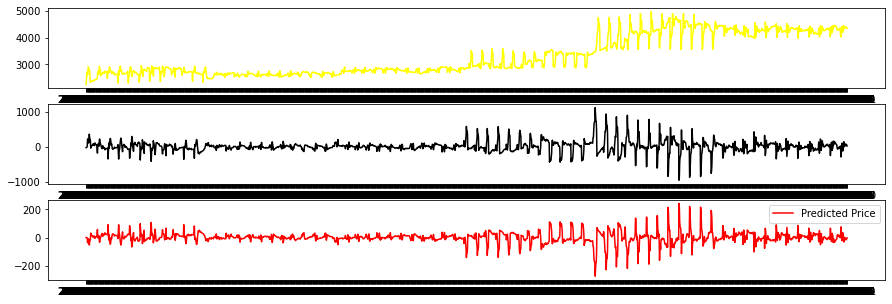

In [68]:
plt.figure(figsize=(15,5))
plt.title("ARIMA model")
plt.xticks(rotation=45)
plt.subplot(3,1,1)
plt.plot(g_df.price,color='yellow',label='True')
plt.subplot(3,1,2)
plt.plot(rem_ewma_price[0:-1], color='black',label='Actual Price')
plt.subplot(3,1,3)
plt.plot(model_ARIMA.fittedvalues,color='red', label='Predicted Price')
plt.legend()

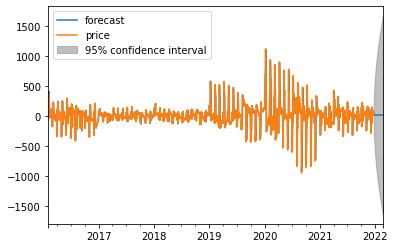

In [59]:
# fit model
model = ARIMA(rem_ewma_price, order=(0, 2, 2))
model_fit = model.fit()
forecast=model_fit.forecast(steps=30)
pred=model_fit.plot_predict(4,2213)
plt.show()

# SARIMA

In [40]:
  

from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(diff_log_price, 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Mani\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_trans   No. Observations:                 2181
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                4367.490
Date:                            Thu, 28 Apr 2022   AIC                          -8724.980
Time:                                    15:42:03   BIC                          -8696.573
Sample:                                01-02-2016   HQIC                         -8714.592
                                     - 12-21-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9994      0.025    -40.527      0.000      -1.048      -0.951
ar.S.L12      -0.0152      0.024     -0.627      0.531      -0.063       0.032
ar.S.L24      -0.1403      0.016     -8.594      0.000      -0.172      -0.108
ma.S.L12      -0.9996      0.122     -8.163      0.000      -1.240      -0.760
sigma2         0.0010      0.000      8.271      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):             17360.99
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                            -1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
np.exp(result.predict(start=len(diff_log_price),end=len(diff_log_price)+30))

2021-12-22    1.000371
2021-12-23    1.000333
2021-12-24    1.003720
2021-12-25    0.994797
2021-12-26    1.006549
2021-12-27    1.008264
2021-12-28    0.993546
2021-12-29    0.992686
2021-12-30    0.997997
2021-12-31    1.002608
2022-01-01    1.006425
2022-01-02    0.998770
2022-01-03    0.999029
2022-01-04    0.994564
2022-01-05    1.006083
2022-01-06    0.996828
2022-01-07    1.003343
2022-01-08    1.000001
2022-01-09    0.997418
2022-01-10    0.997399
2022-01-11    1.001644
2022-01-12    0.999538
2022-01-13    1.002772
2022-01-14    1.000271
2022-01-15    1.000494
2022-01-16    1.000521
2022-01-17    1.001822
2022-01-18    0.998103
2022-01-19    1.001721
2022-01-20    0.999633
2022-01-21    0.999902
Freq: D, Name: predicted_mean, dtype: float64